## GLENS analysis - Land output

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import nc_time_axis
import cf_xarray 
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib as mpl

### Define file paths, variables

file paths

In [2]:
ctrl_lnd_path = '/glade/scratch/kdagon/GLENS/control/lnd/'
fdbk_lnd_path = '/glade/scratch/kdagon/GLENS/feedback/lnd/'
ctrl_atm_path = '/glade/scratch/kdagon/GLENS/control/atm/'
fdbk_atm_path = '/glade/scratch/kdagon/GLENS/feedback/atm/'

set variable(s) of interest

In [3]:
var = 'EFLX_LH_TOT'

define variable path(s)

In [ ]:
ctrl_lnd_path_var = ctrl_lnd_path+var+'/'
fdbk_land_path_var = fdbk_lnd_path+var+'/'

### Read in multiple ensemble members/years

set number of ensemble members

In [ ]:
nens = 20

define ensemble member dim to concat

In [ ]:
ensdim = xr.DataArray(np.array(range(nens)), dims='ens', name='ens')
dims = [ensdim,'time']

create the file lists, noting ensemble members have different number of files (due to time ranges)

In [ ]:
ctrl_lnd_files = [ctrl_lnd_path_var+'*'+str(e+1).zfill(3)+'*'+var+'*.nc' for e in range(nens)]
ctrl_lnd_files

In [ ]:
fdbk_lnd_files = [fdbk_land_path_var+'*'+str(e+1).zfill(3)+'*'+var+'*.nc' for e in range(nens)]
fdbk_lnd_files

set control first and last years

In [ ]:
firstyear=2010
lastyear=2030

preprocessing function to fix time bounds, return specific variable only

In [ ]:
def preprocess(ds):
    attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
    time_bounds = ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
    time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
    ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
    ds.time.attrs, ds.time.encoding = attrs, encoding
    return ds[var].sel(time=slice(str(firstyear), str(lastyear)))

read in one file string at a time, then concat

In [ ]:
dsets=[]
for ffs in ctrl_lnd_files:
    df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
    dsets.append(df)
ctrl_lnd_var = xr.concat(dsets,dim=ensdim)

look at the time variable - should be centered in each month

In [ ]:
ctrl_lnd_var.time

quick global mean annual mean timeseries plot

In [ ]:
ctrl_lnd_var.weighted(np.cos(np.deg2rad(ctrl_lnd_var.lat))).mean(("lon","lat")).groupby('time.year').mean('time').plot.line(x='year', add_legend=False);

In [ ]:
ctrl_lnd_var

In [ ]:
# time mean, ensemble mean plot
ctrl_lnd_var.mean(('time','ens')).plot()

now feedback files

In [ ]:
firstyear=2075
lastyear=2095

In [ ]:
dsets=[]
for ffs in fdbk_lnd_files:
    df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
    dsets.append(df)
fdbk_lnd_var = xr.concat(dsets,dim=ensdim)

In [ ]:
fdbk_lnd_var.weighted(np.cos(np.deg2rad(fdbk_lnd_var.lat))).mean(("lon","lat")).groupby('time.year').mean('time').plot.line(x='year', add_legend=False);

In [ ]:
# time mean, ensemble mean diff plot
# have to take the mean before the diff because xarray doesn't like the mismatched time units
diff = (fdbk_lnd_var.mean(('time','ens')) - ctrl_lnd_var.mean(('time','ens')))*86400*365 # convert gC/m2/s to gC/m2/yr
diff.plot(vmin=-500,vmax=500, cmap='seismic')

now control end-of-century (note only 3 ensemble members)

In [ ]:
firstyear=2075
lastyear=2095

In [ ]:
dsets=[]
for ffs in ctrl_lnd_files:
    df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
    dsets.append(df)

# manually subset because only first 3 EMs cover this time period (not sure how to automate this)
nens_red = 3
dsets = dsets[:nens_red]

# new ensemble dim (reduced)
ensdim_red = xr.DataArray(np.array(range(nens_red)), dims='ens', name='ens')
rcp_lnd_var = xr.concat(dsets,dim=ensdim_red)
rcp_lnd_var

In [ ]:
rcp_lnd_var.weighted(np.cos(np.deg2rad(rcp_lnd_var.lat))).mean(("lon","lat")).groupby('time.year').mean('time').plot.line(x='year', add_legend=False);

### Comparison diff plots

In [ ]:
das = [ctrl_lnd_var, fdbk_lnd_var, rcp_lnd_var]
nsim = len(das)
simnames = ['Control, 2010-2030', 'Feedback, 2075-2095', 'Control, 2075-2095']

In [ ]:
diffs = [(das[1].mean(('time','ens')) - das[0].mean(('time','ens')))*86400*365, # feedback - control
         (das[1].mean(('time','ens')) - das[2].mean(('time','ens')))*86400*365, # feedback - rcp
         (das[2].mean(('time','ens')) - das[0].mean(('time','ens')))*86400*365] # rcp - control
diffnames = ['Feedback, 2075-2095 - Control, 2010-2030', 'Feedback, 2075-2095 - RCP8.5, 2075-2095', 'RCP8.5, 2075-2095 - Control, 2010-2030']

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})
for j in range(nsim):
    
    field, lon = add_cyclic_point(diffs[j], coord=diffs[j].lon)
    lat = diffs[j].lat   
    cf = axs[j].pcolormesh(lon, lat, field, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-500, vmax=500)
    axs[j].coastlines()
    axs[j].set_global()
        
    axs[j].set_title(diffnames[j], fontsize=16)


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.2)

# Colorbar settings - coordinate left and width to be centered
cb_ax = fig.add_axes([0.4, 0.15, 0.2, 0.02])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-500, vmax=500)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')
cb1.ax.set_xlabel('GPP (gC/m^2/yr)', fontsize=14)

#plt.savefig("GPP_diffs.png")

### Write a function to read in given variable for three simulations-time periods

In [3]:
def preprocess(ds):
    attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
    time_bounds = ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
    time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
    ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
    ds.time.attrs, ds.time.encoding = attrs, encoding
    return ds[var].sel(time=slice(str(firstyear), str(lastyear)))

In [4]:
def read_var_sims(var):
    
    # variable file paths
    ctrl_lnd_path_var = ctrl_lnd_path+var+'/'
    fdbk_land_path_var = fdbk_lnd_path+var+'/'
    
    # number of ensemble members - maybe make this an input to the function?
    nens = 20
    
    # define ensemble member dim
    ensdim = xr.DataArray(np.array(range(nens)), dims='ens', name='ens')
    dims = [ensdim,'time']
    
    # create file lists
    ctrl_lnd_files = [ctrl_lnd_path_var+'*'+str(e+1).zfill(3)+'*'+var+'*.nc' for e in range(nens)]
    fdbk_lnd_files = [fdbk_land_path_var+'*'+str(e+1).zfill(3)+'*'+var+'*.nc' for e in range(nens)]
    
    # set ctrl years - maybe make this function input?
    # these variables are needed for preprocess function (not sure how to pass additional arguments)
    firstyear=2010
    lastyear=2030
    
    # need to define preprocess inside this function to update variable name
    def preprocess(ds):
        attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
        time_bounds = ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
        time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
        ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
        ds.time.attrs, ds.time.encoding = attrs, encoding
        return ds[var].sel(time=slice(str(firstyear), str(lastyear)))
    
    # read one file string at a time, then concat over ensemble members
    dsets=[]
    for ffs in ctrl_lnd_files:
        df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
        dsets.append(df)
    ctrl_lnd_var = xr.concat(dsets,dim=ensdim)
    
    # reset years
    firstyear=2075
    lastyear=2095
    
    # feedback files
    dsets=[]
    for ffs in fdbk_lnd_files:
        df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
        dsets.append(df)
    fdbk_lnd_var = xr.concat(dsets,dim=ensdim)
    
    # rcp files
    dsets=[]
    for ffs in ctrl_lnd_files:
        df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
        dsets.append(df)
    # manually subset because only first 3 EMs cover this time period (not sure how to automate this)
    nens_red = 3
    dsets = dsets[:nens_red]
    # new ensemble dim (reduced)
    ensdim_red = xr.DataArray(np.array(range(nens_red)), dims='ens', name='ens')
    rcp_lnd_var = xr.concat(dsets,dim=ensdim_red)

    return(ctrl_lnd_var, fdbk_lnd_var, rcp_lnd_var)

### Write a function to calculation three ensemble mean, annual mean differences

In [5]:
diffnames = ['Feedback, 2075-2095 - Control, 2010-2030', 'Feedback, 2075-2095 - RCP8.5, 2075-2095', 'RCP8.5, 2075-2095 - Control, 2010-2030']
nsim = len(diffnames)

In [6]:
def calc_sim_diffs(var):
    var_das = read_var_sims(var)
    var_diffs = [(var_das[1].mean(('time','ens')) - var_das[0].mean(('time','ens'))), # feedback - control
         (var_das[1].mean(('time','ens')) - var_das[2].mean(('time','ens'))), # feedback - rcp
         (var_das[2].mean(('time','ens')) - var_das[0].mean(('time','ens')))] # rcp - control

    return(var_diffs)

### GPP

In [17]:
GPP_diffs = calc_sim_diffs('GPP')

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


Text(0.5, 0, 'GPP (gC/m^2/yr)')

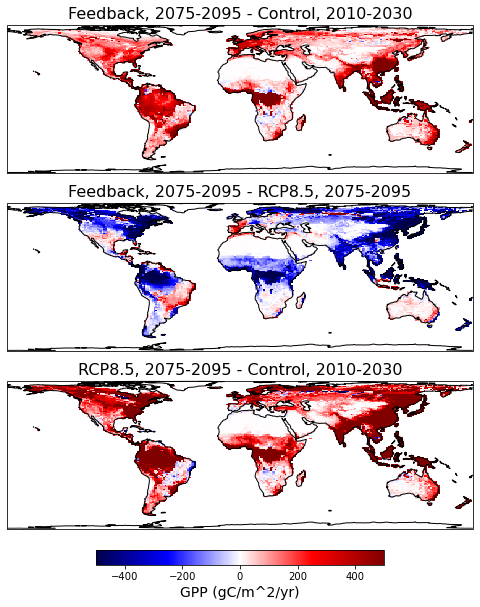

In [33]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})
for j in range(nsim):
    
    field, lon = add_cyclic_point(GPP_diffs[j]*86400*365, coord=GPP_diffs[j].lon) # convert gC/m2/s to gC/m2/yr
    lat = GPP_diffs[j].lat   
    cf = axs[j].pcolormesh(lon, lat, field, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-500, vmax=500)
    axs[j].coastlines()
    axs[j].set_global()
        
    axs[j].set_title(diffnames[j], fontsize=16)


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.2)

# Colorbar settings - coordinate left and width to be centered
cb_ax = fig.add_axes([0.4, 0.15, 0.2, 0.02])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-500, vmax=500)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')
cb1.ax.set_xlabel('GPP (gC/m^2/yr)', fontsize=14);

#plt.savefig("GPP_diffs.png")

what's causing the decrease in GPP (feedback-rcp)? cooling effect?

### FSDSVI

In [8]:
FSDSVI_diffs = calc_sim_diffs('FSDSVI')

In [92]:
FSDSVI_das = read_var_sims(var='FSDSVI')

In [96]:
FSDSVI_diffs = [(FSDSVI_das[1].mean(('time','ens')) - FSDSVI_das[0].mean(('time','ens'))), # feedback - control
         (FSDSVI_das[1].mean(('time','ens')) - FSDSVI_das[2].mean(('time','ens'))), # feedback - rcp
         (FSDSVI_das[2].mean(('time','ens')) - FSDSVI_das[0].mean(('time','ens')))] # rcp - control
diffnames = ['Feedback, 2075-2095 - Control, 2010-2030', 'Feedback, 2075-2095 - RCP8.5, 2075-2095', 'RCP8.5, 2075-2095 - Control, 2010-2030']

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


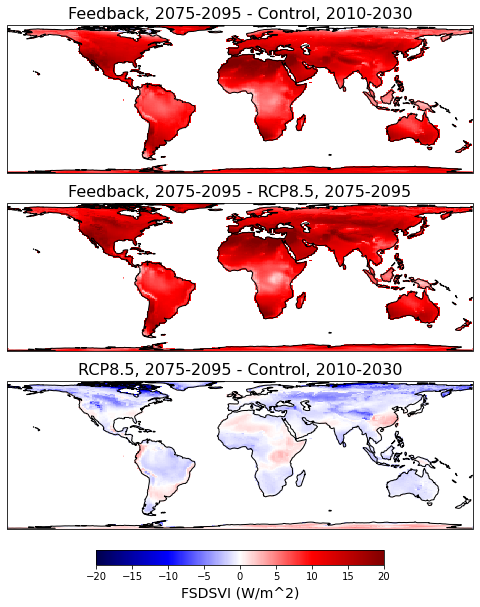

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})
for j in range(nsim):
    
    field, lon = add_cyclic_point(FSDSVI_diffs[j], coord=FSDSVI_diffs[j].lon)
    lat = FSDSVI_diffs[j].lat   
    cf = axs[j].pcolormesh(lon, lat, field, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-20, vmax=20)
    axs[j].coastlines()
    axs[j].set_global()
        
    axs[j].set_title(diffnames[j], fontsize=16)


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.2)

# Colorbar settings - coordinate left and width to be centered
cb_ax = fig.add_axes([0.4, 0.15, 0.2, 0.02])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-20, vmax=20)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')
cb1.ax.set_xlabel('FSDSVI (W/m^2)', fontsize=14);

#plt.savefig("FSDSVI_diffs.png")

### Diffuse fraction

In [98]:
FSDS_das = read_var_sims(var='FSDS')

In [ ]:
# diffuse fraction = FSDSVI/FSDS
diffusefrac_das = [FSDSVI_das[i]/FSDS_das[i] for i in range(3)]
diffusefrac_das[0].mean(('time', 'ens')).plot()

In [104]:
diffusefrac_diffs = [(diffusefrac_das[1].mean(('time','ens')) - diffusefrac_das[0].mean(('time','ens'))), # feedback - control
         (diffusefrac_das[1].mean(('time','ens')) - diffusefrac_das[2].mean(('time','ens'))), # feedback - rcp
         (diffusefrac_das[2].mean(('time','ens')) - diffusefrac_das[0].mean(('time','ens')))] # rcp - control

In [ ]:
diffusefrac_diffs[0].plot()

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


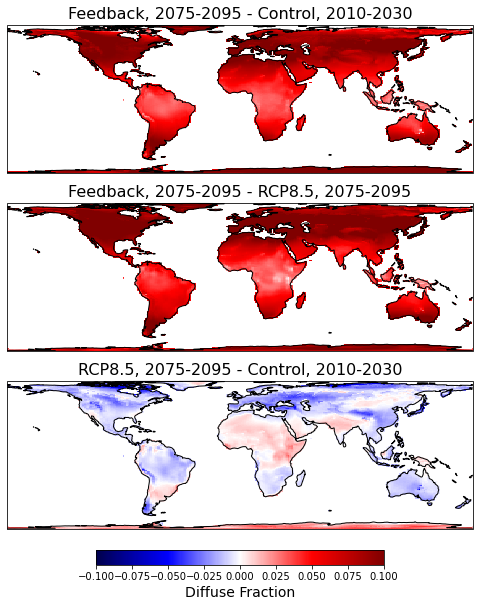

In [108]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})
for j in range(nsim):
    
    field, lon = add_cyclic_point(diffusefrac_diffs[j], coord=diffusefrac_diffs[j].lon)
    lat = diffusefrac_diffs[j].lat   
    cf = axs[j].pcolormesh(lon, lat, field, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-0.1, vmax=0.1)
    axs[j].coastlines()
    axs[j].set_global()
        
    axs[j].set_title(diffnames[j], fontsize=16)


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.2)

# Colorbar settings - coordinate left and width to be centered
cb_ax = fig.add_axes([0.4, 0.15, 0.2, 0.02])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-0.1, vmax=0.1)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')
cb1.ax.set_xlabel('Diffuse Fraction', fontsize=14);

#plt.savefig("diffusefrac_diffs.png")

### Latent Heat Flux

In [13]:
LH_diffs = calc_sim_diffs('EFLX_LH_TOT')

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


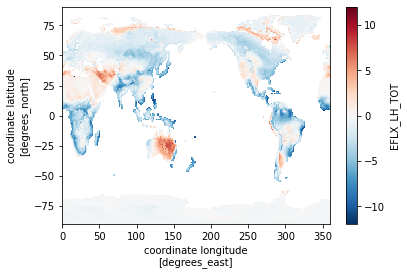

In [16]:
# quick plot to get a sense of contour bounds - is there a way to automate this?
LH_diffs[0].plot()

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


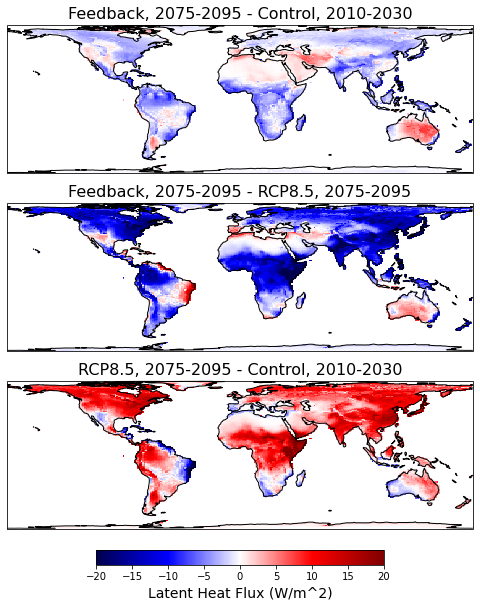

In [23]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})
for j in range(nsim):
    
    field, lon = add_cyclic_point(LH_diffs[j], coord=LH_diffs[j].lon)
    lat = LH_diffs[j].lat   
    cf = axs[j].pcolormesh(lon, lat, field, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-20, vmax=20)
    axs[j].coastlines()
    axs[j].set_global()
        
    axs[j].set_title(diffnames[j], fontsize=16)


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.2)

# Colorbar settings - coordinate left and width to be centered
cb_ax = fig.add_axes([0.4, 0.15, 0.2, 0.02])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-20, vmax=20)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')
cb1.ax.set_xlabel('Latent Heat Flux (W/m^2)', fontsize=14);

#plt.savefig("LHF_diffs.png")

### 10cm Soil Moisture

In [24]:
SM10_diffs = calc_sim_diffs('SOILWATER_10CM')

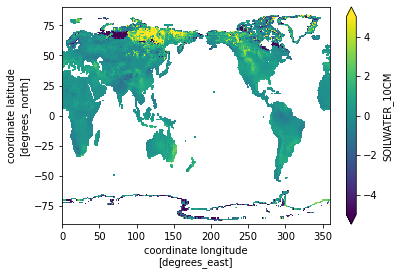

In [28]:
# quick plot to get a sense of contour bounds - is there a way to automate this?
SM10_diffs[0].plot(vmin=-5,vmax=5)

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


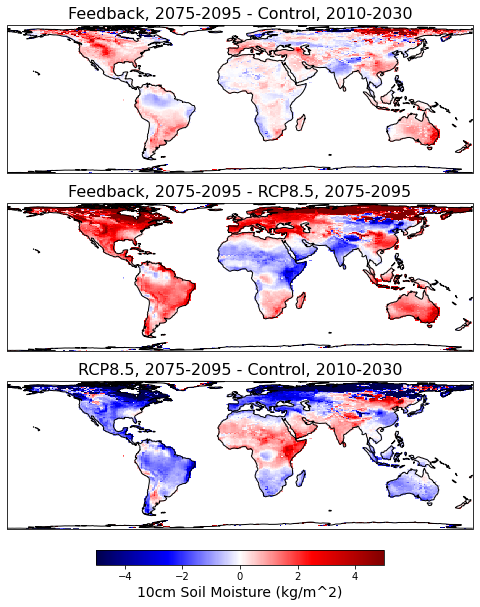

In [34]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})
for j in range(nsim):
    
    field, lon = add_cyclic_point(SM10_diffs[j], coord=SM10_diffs[j].lon)
    lat = SM10_diffs[j].lat   
    cf = axs[j].pcolormesh(lon, lat, field, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-5, vmax=5)
    axs[j].coastlines()
    axs[j].set_global()
        
    axs[j].set_title(diffnames[j], fontsize=16)


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.2)

# Colorbar settings - coordinate left and width to be centered
cb_ax = fig.add_axes([0.4, 0.15, 0.2, 0.02])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-5, vmax=5)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')
cb1.ax.set_xlabel('10cm Soil Moisture (kg/m^2)', fontsize=14);

#plt.savefig("SM10_diffs.png")

### NPP

In [7]:
NPP_diffs = calc_sim_diffs('NPP')

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


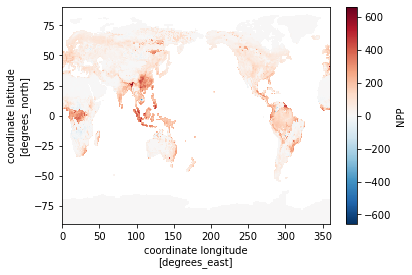

In [10]:
(NPP_diffs[0]*86400*365).plot()

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


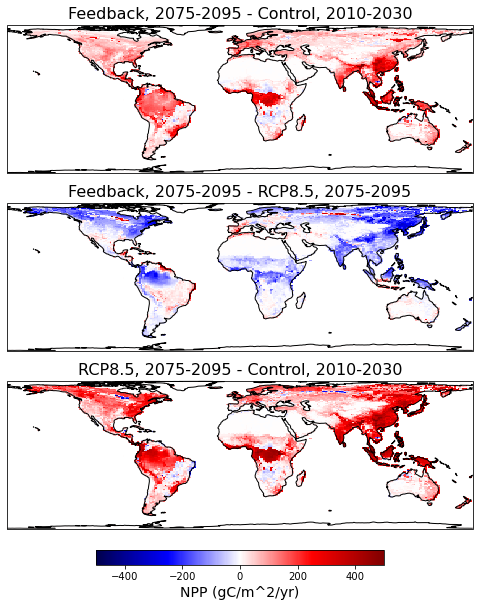

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})
for j in range(nsim):
    
    field, lon = add_cyclic_point(NPP_diffs[j]*86400*365, coord=NPP_diffs[j].lon) # convert gC/m2/s to gC/m2/yr
    lat = NPP_diffs[j].lat   
    cf = axs[j].pcolormesh(lon, lat, field, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-500, vmax=500)
    axs[j].coastlines()
    axs[j].set_global()
        
    axs[j].set_title(diffnames[j], fontsize=16)


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.2)

# Colorbar settings - coordinate left and width to be centered
cb_ax = fig.add_axes([0.4, 0.15, 0.2, 0.02])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-500, vmax=500)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')
cb1.ax.set_xlabel('NPP (gC/m^2/yr)', fontsize=14);

#plt.savefig("NPP_diffs.png", bbox_inches='tight')

### Autotrophic Respiration

In [13]:
AR_diffs = calc_sim_diffs('AR')

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


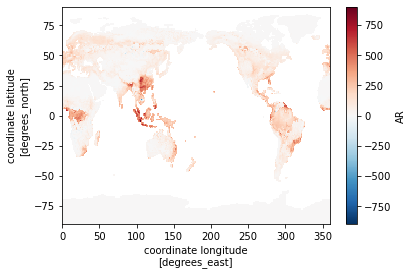

In [14]:
(AR_diffs[0]*86400*365).plot()

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


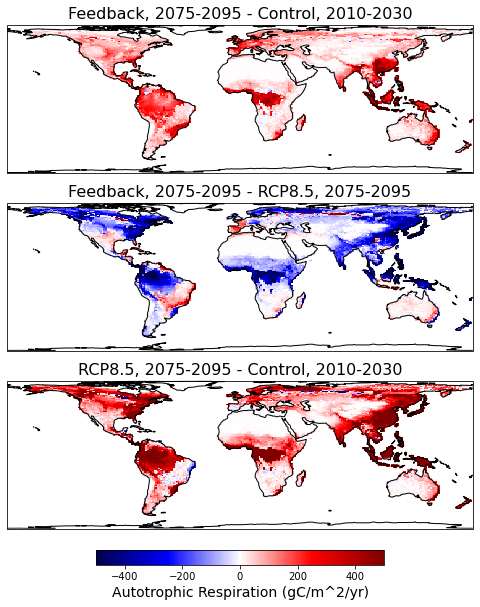

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})
for j in range(nsim):
    
    field, lon = add_cyclic_point(AR_diffs[j]*86400*365, coord=AR_diffs[j].lon) # convert gC/m2/s to gC/m2/yr
    lat = AR_diffs[j].lat   
    cf = axs[j].pcolormesh(lon, lat, field, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-500, vmax=500)
    axs[j].coastlines()
    axs[j].set_global()
        
    axs[j].set_title(diffnames[j], fontsize=16)


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=0.2)

# Colorbar settings - coordinate left and width to be centered
cb_ax = fig.add_axes([0.4, 0.15, 0.2, 0.02])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-500, vmax=500)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')
cb1.ax.set_xlabel('Autotrophic Respiration (gC/m^2/yr)', fontsize=14);

#plt.savefig("AR_diffs.png", bbox_inches='tight')

### Carbon balance check

Verify NPP = GPP - AR

In [18]:
GPP_das = read_var_sims('GPP')

In [20]:
GPP_das[0]

<xarray.DataArray 'GPP' (ens: 20, time: 252, lat: 192, lon: 288)>
dask.array<concatenate, shape=(20, 252, 192, 288), dtype=float32, chunksize=(1, 120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2010-01-16 11:45:00 ... 2030-12-16 12:00:00
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Attributes:
    units:         gC/m^2/s
    long_name:     gross primary production
    cell_methods:  time: mean

In [21]:
NPP_das = read_var_sims('NPP')
AR_das = read_var_sims('AR')

In [29]:
NPPcheck = GPP_das[0] - AR_das[0]
NPPcheck

<xarray.DataArray (ens: 20, time: 252, lat: 192, lon: 288)>
dask.array<sub, shape=(20, 252, 192, 288), dtype=float32, chunksize=(1, 120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2010-01-16 11:45:00 ... 2030-12-16 12:00:00
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19

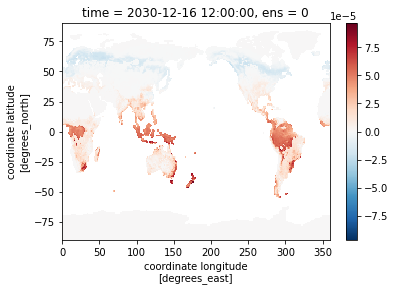

In [33]:
NPPcheck.isel(ens=0,time=251).plot()

In [30]:
cBalcheck = NPP_das[0] - NPPcheck

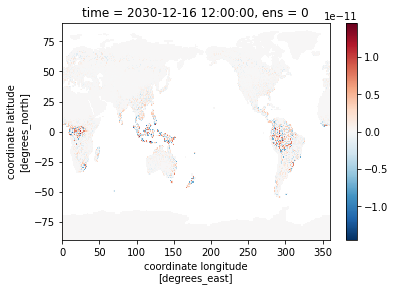

In [31]:
# spot check first ensemble member, last time point
cBalcheck.isel(ens=0,time=251).plot()

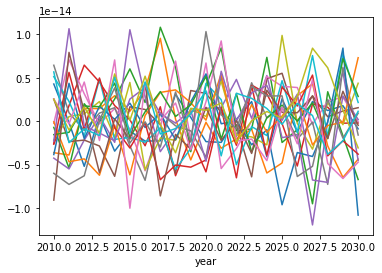

In [32]:
# global mean, annual mean timeseries across ensemble members
cBalcheck.weighted(np.cos(np.deg2rad(cBalcheck.lat))).mean(("lon","lat")).groupby('time.year').mean('time').plot.line(x='year', add_legend=False);

Differences are extremely small/negligible

### Write a function to calculation three ensemble mean, annual mean, zonal mean differences

In [34]:
def calc_sim_diffs_zmean(var):
    var_das = read_var_sims(var)
    var_diffs = [(var_das[1].mean(('time','ens','lon')) - var_das[0].mean(('time','ens','lon'))), # feedback - control
         (var_das[1].mean(('time','ens','lon')) - var_das[2].mean(('time','ens','lon'))), # feedback - rcp
         (var_das[2].mean(('time','ens','lon')) - var_das[0].mean(('time','ens','lon')))] # rcp - control

    return(var_diffs)

### Zonal mean Carbon Fluxes

In [35]:
GPP_diffs_zmean = calc_sim_diffs_zmean('GPP')

In [36]:
GPP_diffs_zmean[0]

<xarray.DataArray 'GPP' (lat: 192)>
dask.array<sub, shape=(192,), dtype=float32, chunksize=(192,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0

In [37]:
NPP_diffs_zmean = calc_sim_diffs_zmean('NPP')
AR_diffs_zmean = calc_sim_diffs_zmean('AR')

In [42]:
# subset lats from -60S, 75N
GPP_diffs_zmean[0].sel(lat=slice(-60,75))

<xarray.DataArray 'GPP' (lat: 144)>
dask.array<getitem, shape=(144,), dtype=float32, chunksize=(144,), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -59.84 -58.9 -57.96 -57.02 ... 73.04 73.98 74.92

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/ar

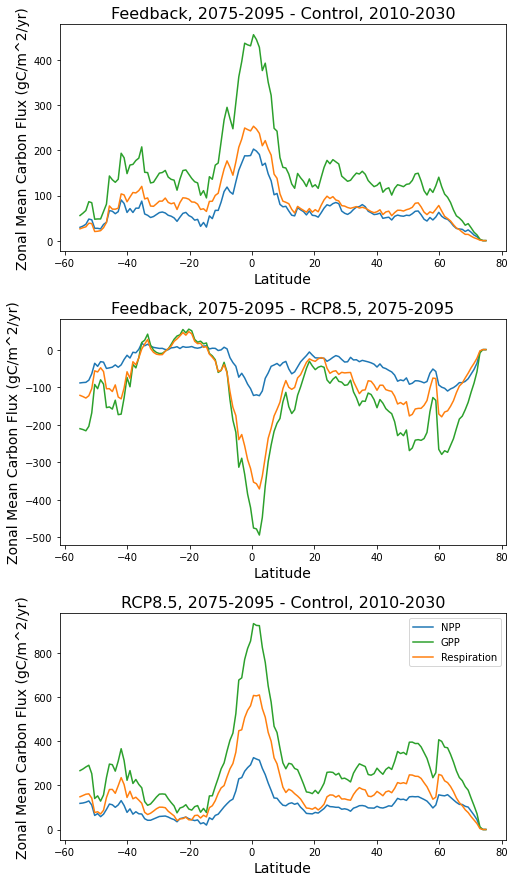

In [45]:
fig, axs = plt.subplots(3, 1, figsize=(8, 15))
for j in range(nsim):
    
    axs[j].plot(NPP_diffs_zmean[j].sel(lat=slice(-60,75)).lat, NPP_diffs_zmean[j].sel(lat=slice(-60,75))*86400*365, label='NPP', color='C0') # convert gC/m2/s to gC/m2/yr
    axs[j].plot(GPP_diffs_zmean[j].sel(lat=slice(-60,75)).lat, GPP_diffs_zmean[j].sel(lat=slice(-60,75))*86400*365, label='GPP', color='C2') 
    axs[j].plot(AR_diffs_zmean[j].sel(lat=slice(-60,75)).lat, AR_diffs_zmean[j].sel(lat=slice(-60,75))*86400*365, label='Respiration', color='C1')
    axs[j].set_title(diffnames[j], fontsize=16)
    axs[j].set_xlabel('Latitude', fontsize=14)
    axs[j].set_ylabel('Zonal Mean Carbon Flux (gC/m^2/yr)', fontsize=14)

plt.legend()
plt.subplots_adjust(hspace=0.3)
#plt.savefig("CarbonFluxes_zmean_diffs.png", bbox_inches='tight')

### Zonal mean Water Fluxes

In [46]:
QVEGT_diffs_zmean = calc_sim_diffs_zmean('QVEGT')

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


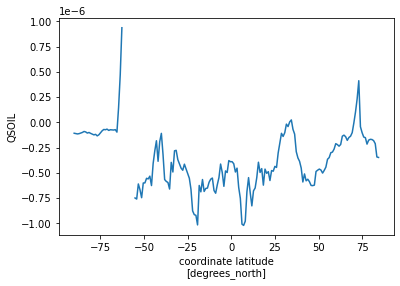

In [51]:
QSOIL_diffs_zmean[0].plot()

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


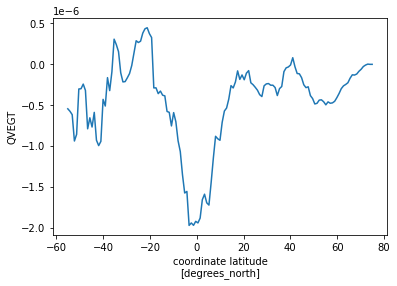

In [49]:
QVEGT_diffs_zmean[0].sel(lat=slice(-60,75)).plot()

In [47]:
QVEGE_diffs_zmean = calc_sim_diffs_zmean('QVEGE')
QSOIL_diffs_zmean = calc_sim_diffs_zmean('QSOIL')

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/ar

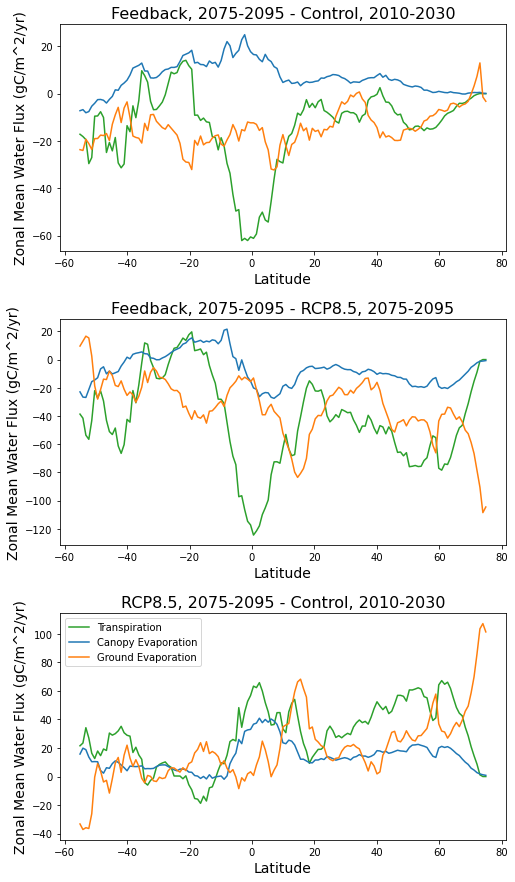

In [53]:
fig, axs = plt.subplots(3, 1, figsize=(8, 15))
for j in range(nsim):
    
    axs[j].plot(QVEGT_diffs_zmean[j].sel(lat=slice(-60,75)).lat, QVEGT_diffs_zmean[j].sel(lat=slice(-60,75))*86400*365, label='Transpiration', color='C2') # convert mm/s to mm/yr
    axs[j].plot(QVEGE_diffs_zmean[j].sel(lat=slice(-60,75)).lat, QVEGE_diffs_zmean[j].sel(lat=slice(-60,75))*86400*365, label='Canopy Evaporation', color='C0') 
    axs[j].plot(QSOIL_diffs_zmean[j].sel(lat=slice(-60,75)).lat, QSOIL_diffs_zmean[j].sel(lat=slice(-60,75))*86400*365, label='Ground Evaporation', color='C1')
    axs[j].set_title(diffnames[j], fontsize=16)
    axs[j].set_xlabel('Latitude', fontsize=14)
    axs[j].set_ylabel('Zonal Mean Water Flux (gC/m^2/yr)', fontsize=14)

plt.legend()
plt.subplots_adjust(hspace=0.3)
#plt.savefig("WaterFluxes_zmean_diffs.png", bbox_inches='tight')

### To Do
Annual/zonal mean diffs for three comparisons as above (other relevant variables)\
Seasonal changes?\
Climate classifications?